In [1]:
import sys, os

sys.path.append('/cr/users/filip/bin/')

from utils.binaries import *
from utils.plotting import *

14:10:15 [INFO] utils          -- ( +2192ms) -- import logging
14:10:15 [INFO] utils.binaries -- (  +139ms) -- import numpy as np
14:10:15 [INFO] utils.binaries -- (    +7ms) -- import uncertainties
14:10:15 [INFO] utils.binaries -- (  +174ms) -- import pandas as pd
14:10:15 [INFO] utils.binaries -- (    +1ms) -- import binaries.tools as tools
14:10:16 [INFO] utils.plotting -- (  +566ms) -- import matplotlib.pyplot as plt
14:10:16 [INFO] utils.plotting -- (  +281ms) -- import seaborn as so
14:10:16 [DBUG] utils.plotting -- (    +6ms) -- font size set to 9.5
14:10:16 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
14:10:16 [DBUG] utils.plotting -- (    +0ms) -- figure size set to [6.6, 3.3]
14:10:16 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
14:10:16 [DBUG] utils.plotting -- (    +0ms) -- usetex set to False
14:10:16 [INFO] utils.plotting -- (    +2ms) -- import plotting.tools as plot


In [2]:
heat_runs = pd.read_csv('/cr/data01/filip/xy-calibration/config/calib_runlists/heat_runs_all.list', sep=';')

In [27]:
# selection cuts
heat_runs['comment'] = heat_runs['comment'].str.strip()
XY_runs_good = heat_runs[[comment != '"incomplete run, 1319 events"'
                          and db == 1
                          and sphere != 'KIT'
                          for comment, db, sphere in zip(heat_runs['comment'], heat_runs['for_DB'], heat_runs['source'])]]


In [28]:
XY_runs_good

,#runid,telescope,stepsize_cm,date,source,ledCurrent_mA,for_DB,jobfile,comment
2,04516x,he1,6,2019-11-26,OLO,15.9,1,job_HEAT_bay1-CZ_hex_s60_r0-1300_cut.txt,"""reversed positions"""
8,04530x,he3,6,2019-11-27,OLO,15.9,1,job_HEAT_bay3-CZ_hex_s60_r0-1300_cut.txt,"""reversed positions"""
11,04547x,he2,6,2019-11-27,OLO,15.9,1,job_HEAT_bay2-CZ_hex_s60_r0-1300_cut.txt,"""reversed positions"""
16,05616x,he1,6,2022-10-21,"""OLO""",15.9,1,"""job_HEAT_bay1-CZ_hex_s60_r0-1300_cut.txt""",""""""
19,05621x,he2,6,2022-10-21,"""OLO""",15.9,1,"""job_HEAT_bay2-CZ_hex_s60_r0-1300_cut.txt""",""""""
22,05626x,he3,6,2022-10-21,"""OLO""",15.9,1,"""job_HEAT_bay3-CZ_hex_s60_r0-1300_cut.txt""",""""""
31,6020x,he1,6,2023-10-13,"""OLO""",15.9,1,"""job_HEAT_bay1-CZ_hex_s60_r0-1300_cut.txt""",""""""
34,6025,he2,6,2023-10-13,"""OLO""",15.9,1,"""job_HEAT_bay2-CZ_hex_s60_r0-1300_cut.txt""",""""""
40,6031x,he3,6,2023-10-14,"""OLO""",15.9,1,"""job_HEAT_bay3-CZ_hex_s60_r0-1300_cut.txt""",""""""
43,6066,he3,6,2023-11-09,"""OLO""",15.9,1,"""job_HEAT_bay3_hex_s60_r0-1300_cut.txt""",""""""


In [29]:
XY_measurements = {'he1' : [], 'he2' : [], 'he3' : []}

for index, measurement in XY_runs_good.iterrows():

    (runid, telescope), date = measurement[:2], measurement['date'].strip()

    same_day = heat_runs[[d.strip() == date for d in heat_runs['date']]]
    same_telescope = same_day[[t.strip() == telescope.strip() for t in same_day['telescope']]]

    year, month, day = date.split('-')

    XY_measurement = {'XY' : measurement['#runid'], 
                      'CalA_closed_shutter' : [None, None], 
                      'CalA_open_shutter' : [None, None], 
                      'date' : f"{year}{month}".replace('10','oct').replace('11','nov')}

    # find Cal A closed shutter
    for candidate_index, candidate in same_telescope.iterrows():
        if candidate['comment'] == '"Cal A"':
            if candidate_index < index: XY_measurement['CalA_closed_shutter'][0] = candidate['#runid']
            if candidate_index > index: XY_measurement['CalA_closed_shutter'][1] = candidate['#runid']
        if candidate['comment'] == '"Cal A open shutter"':
            if candidate_index < index: XY_measurement['CalA_open_shutter'][0] = candidate['#runid']
            if candidate_index > index: XY_measurement['CalA_open_shutter'][1] = candidate['#runid']

    XY_measurements[telescope.strip()].append(XY_measurement)

In [35]:
import pickle

# save events to disk
with open('/cr/users/filip/Projects/XYScanner/all_heat_measurements.pickle', "wb") as f:
    pickle.dump(XY_measurements, f, pickle.HIGHEST_PROTOCOL)

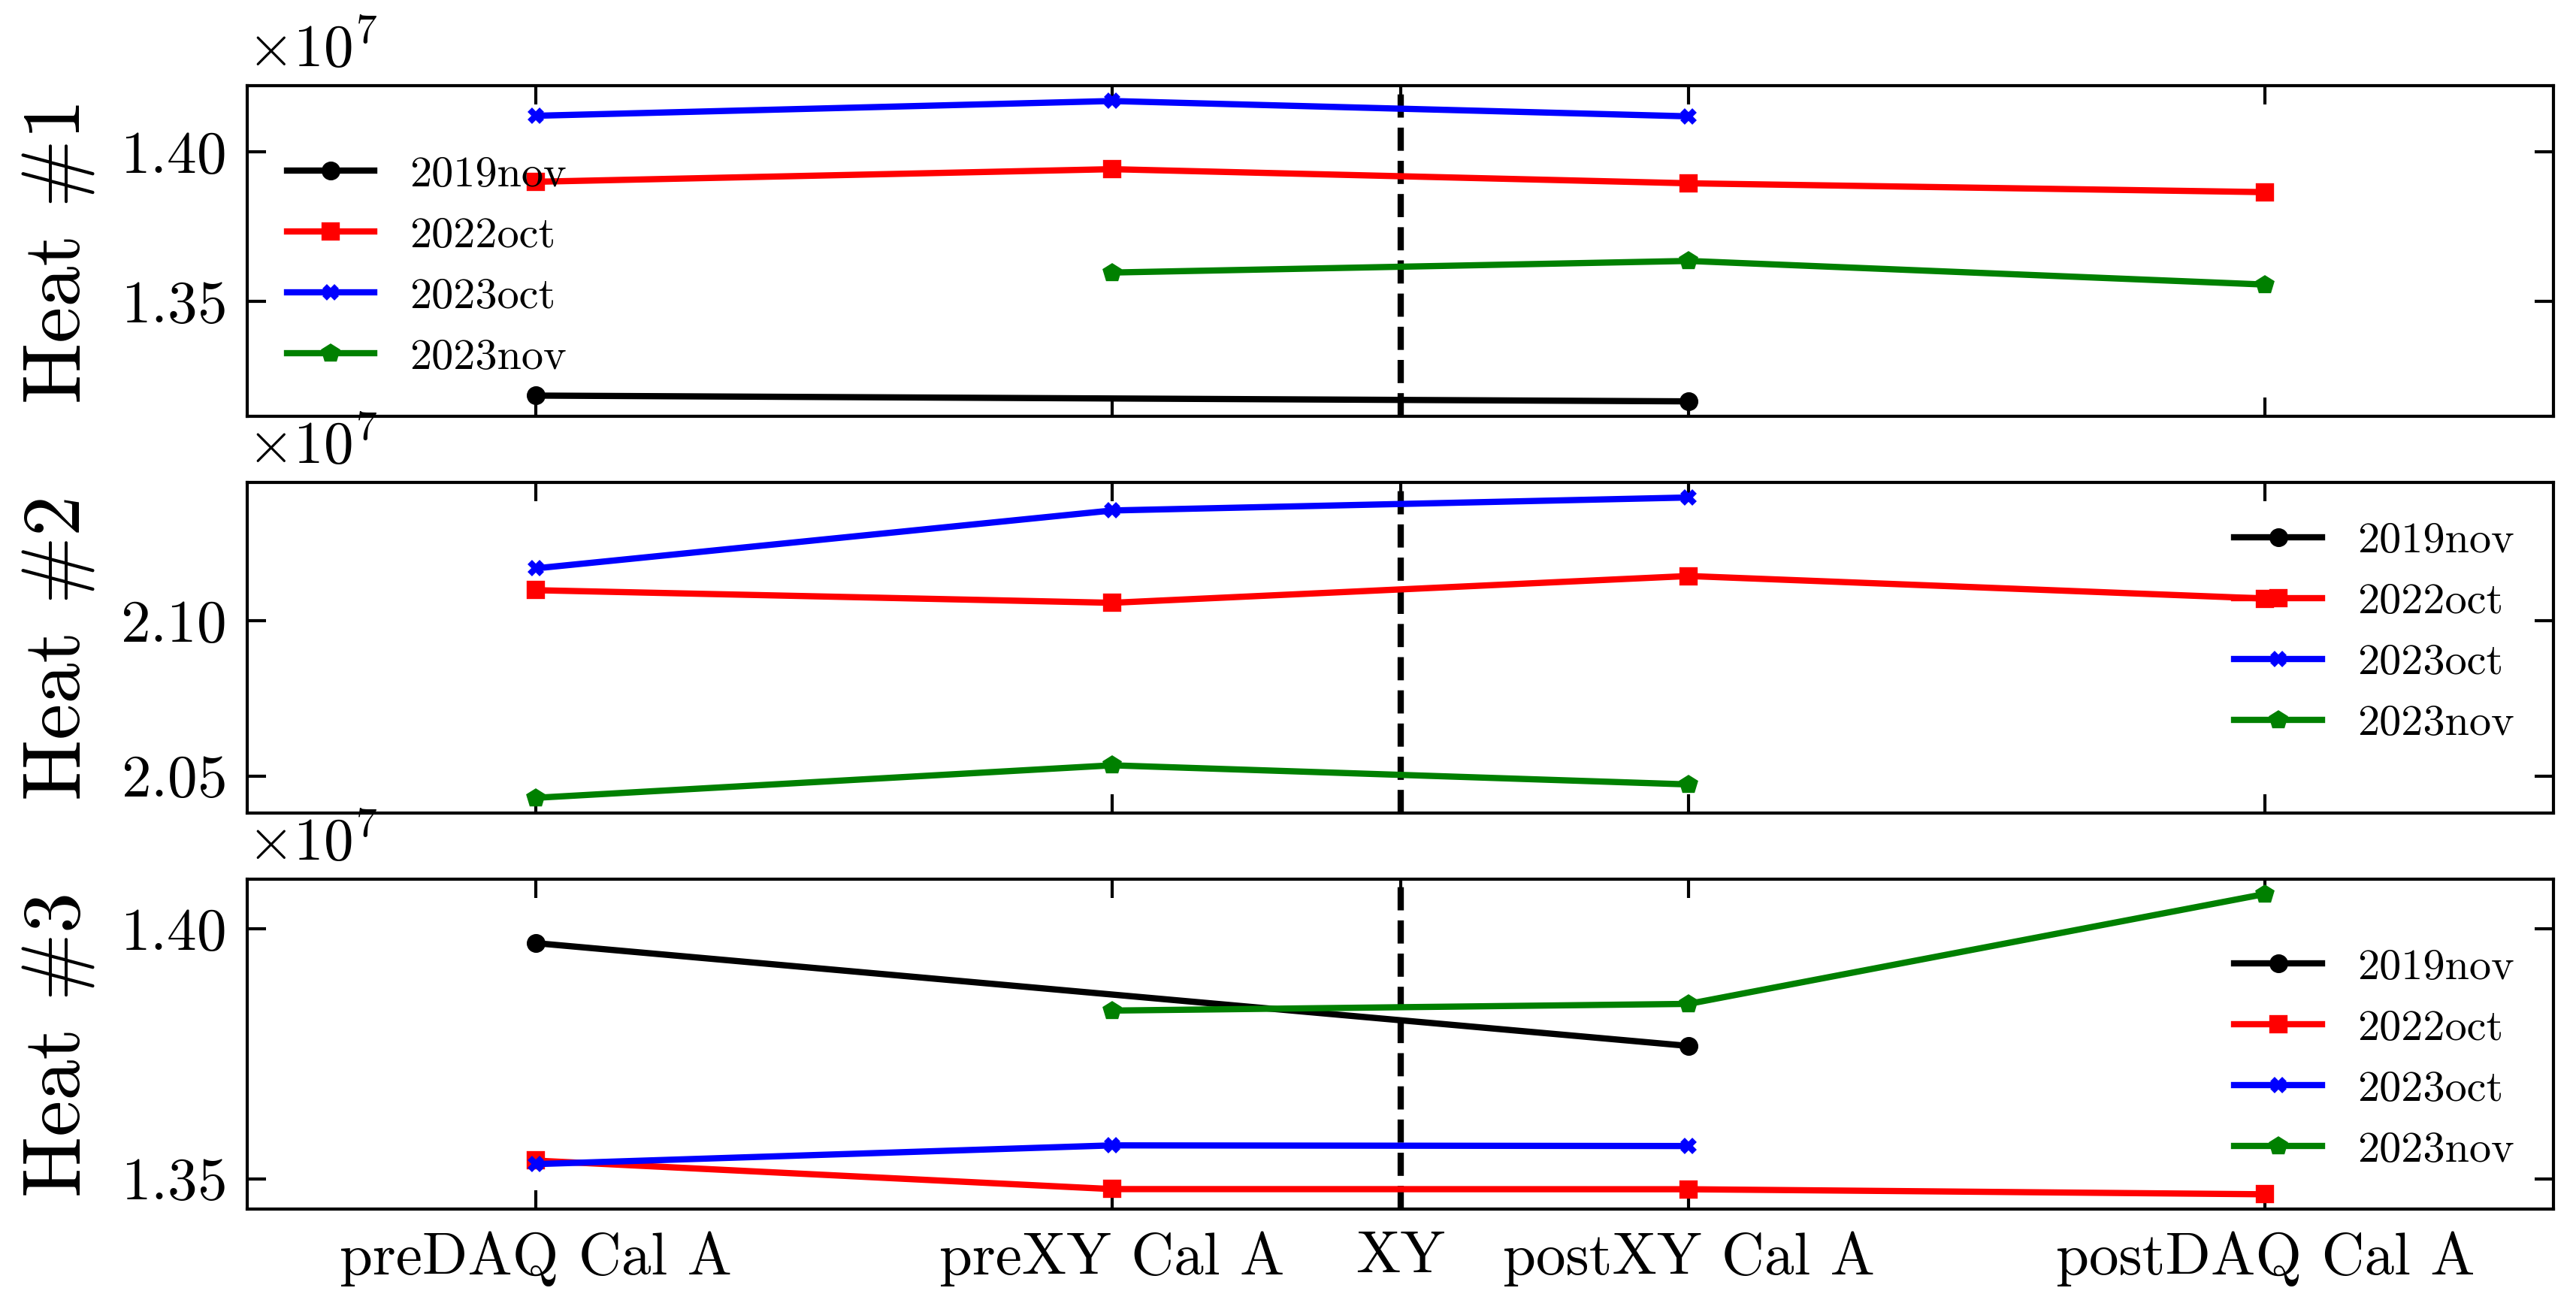

In [34]:
fig, axes = plt.subplots(3, 1, sharex=True)
data_directory = '/cr/data01/filip/xy-calibration/results'
fmt = ['o-', 's-', 'x-', 'p-', 'v-']

for ax, telescope in zip(axes, XY_measurements.keys()):

    ax.axvline(2.5, c='k', ls='--')

    for i, measurement in enumerate(XY_measurements[telescope]):
        
        x, y = [], []
        
        if measurement['CalA_closed_shutter'][0] is not None:
            pre_cal_a_closed_shutter = np.loadtxt(f"{data_directory}/out_{measurement['CalA_closed_shutter'][0]}.txt")
            x.append(1), y.append(np.sum(pre_cal_a_closed_shutter[2]))
        
        if measurement['CalA_open_shutter'][0] is not None:
            pre_cal_a_open_shutter = np.loadtxt(f"{data_directory}/out_{measurement['CalA_open_shutter'][0]}.txt")
            x.append(2), y.append(np.sum(pre_cal_a_open_shutter[2]))

        XY_measurement = ...

        if measurement['CalA_open_shutter'][1] is not None:
            post_cal_a_open_shutter = np.loadtxt(f"{data_directory}/out_{measurement['CalA_open_shutter'][1]}.txt")
            x.append(3), y.append(np.sum(post_cal_a_open_shutter[2]))

        if measurement['CalA_closed_shutter'][1] is not None:
            post_cal_a_closed_shutter = np.loadtxt(f"{data_directory}/out_{measurement['CalA_closed_shutter'][1]}.txt")
            x.append(4), y.append(np.sum(post_cal_a_closed_shutter[2]))

        ax.errorbar(x, y, label=measurement['date'], fmt=fmt[i])

    ax.set_xticks([1, 2, 2.5, 3, 4], ['preDAQ Cal A', 'preXY Cal A', 'XY', 'postXY Cal A', 'postDAQ Cal A'])
    ax.set_xlim(0.5, 4.5)
    ax.minorticks_off()
    ax.legend(fontsize=7)

    ax.set_ylabel(telescope.replace('he', 'Heat #'))